# Tutorial #0b: Backpropagation with PCX

PCX can be used to train standard artificial aeural networks with backpropagation be removing the `vodes` from a model and adjusting the training loop. 

In [1]:
# Install dependencies not included in the base requirements.txt

!pip install scikit-learn matplotlib

/bin/bash: /share/amine.mcharrak/miniconda3/envs/pcax24/bin/pip: /home/amine.mcharrak/miniconda3/envs/pcax24/bin/python: bad interpreter: No such file or directory


In [2]:
from typing import Callable

# These are the default import names used in tutorials and documentation.
import jax
import pcx as px
import pcx.nn as pxnn
import pcx.functional as pxf
import pcx.utils as pxu

# px.RKG is the default key generator used in pcx, which is used as default
# source of randomness within pcx. Here we set its seed to 0 for more reproducibility.
# By default it is initialised with the system time.
px.RKG.seed(0)

In [3]:
# Note how we inherit from Module and not pxc.EnergyModule as we do not have an energy function anymore.
class Model(px.Module):
    def __init__(
        self, input_dim: int, hidden_dim: int, output_dim: int, nm_layers: int, act_fn: Callable[[jax.Array], jax.Array]
    ) -> None:
        super().__init__()

        self.act_fn = px.static(act_fn)

        self.layers = (
            [pxnn.Linear(input_dim, hidden_dim)]
            + [pxnn.Linear(hidden_dim, hidden_dim) for _ in range(nm_layers - 2)]
            + [pxnn.Linear(hidden_dim, output_dim)]
        )

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = self.act_fn(layer(x))

        x = self.layers[-1](x)

        return x

In [4]:
def ce_loss(output, one_hot_label):
    return (-one_hot_label * jax.nn.log_softmax(output)).sum()

# We specify that the keyword argument 'model' has no parameters to be vmaped over.
# Also, we do not provide any `y` value as there is no vode for it.
@pxf.vmap({"model": None}, in_axes=0, out_axes=0)
def forward(x, *, model: Model):
    return model(x)


# Instead, we provide the label `y` in the loss function, as normally done in deep learning.
@pxf.vmap({"model": None}, in_axes=(0, 0), out_axes=(None, 0), axis_name="batch")
def loss(x, y, *, model: Model):
    y_ = model(x)
    return jax.lax.pmean(ce_loss(y_, y), "batch"), y_

In [5]:
# We removed unnnecessary parameters from the function signature. This also requires removing the `static_argnums` argument.
@pxf.jit()
def train_on_batch(
    x: jax.Array,
    y: jax.Array,
    *,
    model: Model,
    optim_w: pxu.Optim
):
    print("Training!")  # this will come in handy later

    # This only sets an internal flag to be "train" (instead of "eval")
    model.train()
    
    # No need for a forward pass as there is no vode to initialise.
    
    # No need for inference steps as well!
    
    # Weight update step
    # The `pxu.step` function is actually not doing anything right now, but we keep it anyway for consistency
    # (also in the future it may do something, who knows?).
    with pxu.step(model):
        (e, y_), g = pxf.value_and_grad(pxu.M(pxnn.LayerParam).to([False, True]), has_aux=True)(loss)(x, y, model=model)
    
    # Note there is not gradient scaling as we have already taken the mean of the loss, not its sum.
    optim_w.step(model, g["model"])

In [6]:
import numpy as np

# Not much to say here, very similar as with PC, since also in PC we used a forward pass to compute the output.
@pxf.jit()
def eval_on_batch(x: jax.Array, y: jax.Array, *, model: Model):
    model.eval()
    
    with pxu.step(model):
        y_ = forward(x, model=model).argmax(axis=-1)
    
    return (y_ == y).mean(), y_


# Standard training loop
def train(dl, *, model: Model, optim_w: pxu.Optim):
    for x, y in dl:
        train_on_batch(x, jax.nn.one_hot(y, 2), model=model, optim_w=optim_w)

# Standard evaluation loop
def eval(dl, *, model: Model):
    acc = []
    ys_ = []
    
    for x, y in dl:
        a, y_ = eval_on_batch(x, y, model=model)
        acc.append(a)
        ys_.append(y_)
    
    return np.mean(acc), np.concatenate(ys_)

In [7]:
import optax

batch_size = 32

model = Model(
    input_dim=2,
    hidden_dim=32,
    output_dim=2,
    nm_layers=3,
    act_fn=jax.nn.leaky_relu
)

In [8]:
optim_w = pxu.Optim(lambda: optax.adamw(1e-2), pxu.M(pxnn.LayerParam)(model))

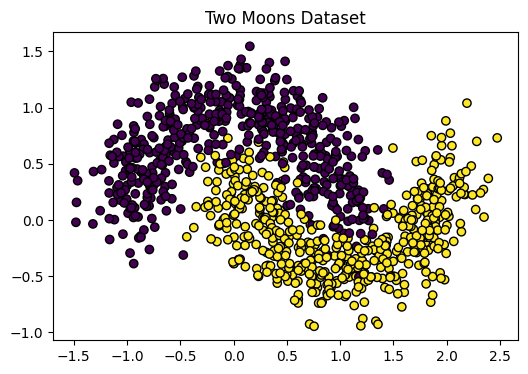

In [9]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# this is unrelated to pcax: we generate and display the training set.
nm_elements = 1024
X, y = make_moons(n_samples=batch_size * (nm_elements // batch_size), noise=0.2, random_state=42)

# Plot the dataset
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title("Two Moons Dataset")
plt.show()

In [10]:
# we split the dataset in training batches and do the same for the generated test set.
train_dl = list(zip(X.reshape(-1, batch_size, 2), y.reshape(-1, batch_size)))

X_test, y_test = make_moons(n_samples=batch_size * (nm_elements // batch_size) // 2, noise=0.2, random_state=0)
test_dl = tuple(zip(X_test.reshape(-1, batch_size, 2), y_test.reshape(-1, batch_size)))

In [11]:
nm_epochs = 256 // (nm_elements // batch_size)

# Note how the text "Training!" appears only once. This is because 'train_on_batch' is executed only once,
# and then its compiled equivalent is instead used (which only cares about what happens to jax.Arrays and
# discards all python code).

for e in range(nm_epochs):
    train(train_dl, model=model, optim_w=optim_w)
    a, y = eval(test_dl, model=model)
    
    # We print the average shift of the first vode during the inference steps. Note that it does not depend on
    # the choice for the batch_size (feel free to play around with it, remember to reset the notebook if you
    # you change it). This is because we multiply the learning rate of 'optim_h' by the batch_size. This is 
    # because the total energy is averaged over the batch dimension (as required for the weight updates),
    # so we need to scale the learning rate accordingly for the vode updates.
    print(f"Epoch {e + 1}/{nm_epochs} - Test Accuracy: {a * 100:.2f}%")

Training!
Epoch 1/8 - Test Accuracy: 87.89%
Epoch 2/8 - Test Accuracy: 93.16%
Epoch 3/8 - Test Accuracy: 96.48%
Epoch 4/8 - Test Accuracy: 97.07%
Epoch 5/8 - Test Accuracy: 96.88%
Epoch 6/8 - Test Accuracy: 96.29%
Epoch 7/8 - Test Accuracy: 96.29%
Epoch 8/8 - Test Accuracy: 96.48%


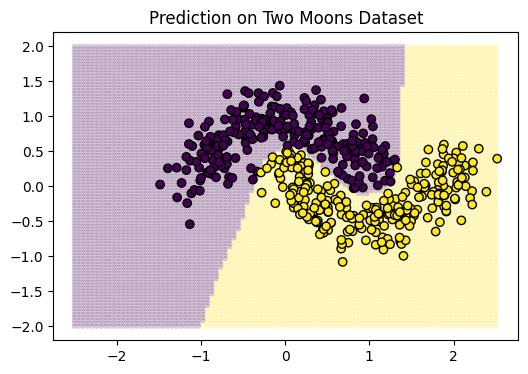

: 

In [12]:
# Test the model on the grid of points in the range [-2.5, 2.5]x[-2.5, 2.5]
X_grid = jax.numpy.stack(np.meshgrid(np.linspace(-2.5, 2.5, 96), np.linspace(-2.0, 2.0, 96))).reshape(2, -1).T
with pxu.step(model):
    y_grid = forward(X_grid, model=model).argmax(axis=-1)

plt.figure(figsize=(6, 4))
plt.scatter(X_grid[:, 0], X_grid[:, 1], c=y_grid, cmap='viridis', s=14, marker='o', linewidths=0, alpha=0.2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title("Prediction on Two Moons Dataset")
plt.show()